Attempted to use PyTorch quantization routines, but failed with tons of errors

In [1]:
from tqdm import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
import math
from matplotlib import pyplot
import numpy as np
from numpy import inf

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path
import requests
import pickle
import struct
import gzip
import io
import time

In [3]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

m = nn.AvgPool2d(2, stride=2)
x_train = m(x_train.reshape((50000, 28, 28))).reshape((50000, 14 * 14))
x_valid = m(x_valid.reshape((10000, 28, 28))).reshape((10000, 14 * 14))

In [4]:
class STE_Round(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Because we are saving one of the inputs use `save_for_backward`
        # Save non-tensors and non-inputs/non-outputs directly on ctx
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_out):
        # A function support double backward automatically if autograd
        # is able to record the computations performed in backward
        return grad_out

def Q(x, s, z, alpha_q, beta_q):
  # WARNING TORCH.ROUND BACKPROP GIVES 0, SHOULD USE STE
  x_q = STE_Round.apply(1/s*x+z)
  #x_q = 1/s * x + z
  return torch.clamp(x_q, min=alpha_q, max=beta_q)

def Q_int8(x, s, z):
  x_q = Q(x, s, z, alpha_q = -127, beta_q = 127)
  return x_q

def Q_uint8(x, s, z):
  x_q = Q(x, s, z, alpha_q = 0, beta_q = 255)
  return x_q

def Q_inv(x_q, s, z):
  return s * (x_q - z)

def Q_matmul_s_only(x, w, s_x, s_w):
  return (x @ w) * s_x * s_w

def FQ_int8(x, s, z):
  return Q_inv(Q_int8(x, s, z), s, z)

def FQ(x, s, z, bins):
  return Q_inv(Q(x, s, z, alpha_q = -bins, beta_q = bins), s, z)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 196])
tensor(0) tensor(9)
torch.Size([50000, 196])
torch.Size([10000, 196])


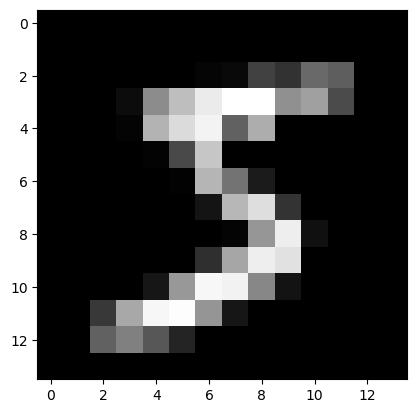

In [5]:
bs = 64  # batch size

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

pyplot.imshow(x_train[0].reshape((round(math.sqrt(c)), round(math.sqrt(c)))), cmap="gray")
print(x_train.shape)
print(x_valid.shape)

In [6]:
x_train = Q_int8(x_train, torch.max(torch.abs(x_train))/(16-1), 0)
x_valid = Q_int8(x_valid, torch.max(torch.abs(x_valid))/(16-1), 0)

In [7]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [15]:
class M(nn.Module):
  def __init__(self, h1):
    super().__init__()
    self.quant = torch.ao.quantization.QuantStub()
    self.l1 = nn.Linear(c, h1)
    self.l2 = nn.Linear(h1, 10)
    self.dequant = torch.ao.quantization.DeQuantStub()
    #self.l3 = FC_Q(10, 10)

  def forward(self, x):
    self.relu = torch.nn.ReLU6()
    self.softmax = torch.nn.Softmax(dim=1)
    x = self.quant(x)
    x = self.relu(self.l1(x))
    x = self.dequant(x)

    x = self.quant(x)
    x = self.softmax(self.l2(x))
    x = self.dequant(x)

    return x

In [24]:
h1 = 64
m = nn.Sequential(
  nn.Linear(c, h1),
  nn.ReLU(),
  nn.Linear(h1, 10),
  nn.Softmax()
)

In [ ]:
model_fp = M(64)

In [29]:
"""Fuse"""
torch.ao.quantization.fuse_modules(model_fp, [['linear','relu']]) # fuse first Linear-ReLU pair
torch.ao.quantization.fuse_modules(model_fp, [['linear','softmax']]) # fuse second Linear-Softmax pair

"""Insert stubs"""
m = nn.Sequential(torch.quantization.QuantStub(), 
                  *m, 
                  torch.quantization.DeQuantStub())

AttributeError: 'M' object has no attribute 'linear'

In [ ]:
model_fp.eval()

M(
  (quant): QuantStub()
  (l1): Linear(in_features=196, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
  (dequant): DeQuantStub()
)

In [ ]:
model_fp.qconfig = torch.ao.quantization.get_default_qat_qconfig('qnnpack')

In [ ]:
model_fp_fused = torch.ao.quantization.fuse_modules(model_fp,
    [['l1', 'bn', 'relu']])

In [30]:
import torch

# define a floating point model where some layers could benefit from QAT
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()
        self.conv = torch.nn.Conv2d(1, 1, 1)
        self.bn = torch.nn.BatchNorm2d(1)
        self.relu = torch.nn.ReLU()
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dequant(x)
        return x

# create a model instance
model_fp32 = M()

# model must be set to eval for fusion to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')

# fuse the activations to preceding layers, where applicable
# this needs to be done manually depending on the model architecture
model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32,
    [['conv', 'bn', 'relu']])

# Prepare the model for QAT. This inserts observers and fake_quants in
# the model needs to be set to train for QAT logic to work
# the model that will observe weight and activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare_qat(model_fp32_fused.train())

# run the training loop (not shown)
# training_loop(model_fp32_prepared)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, fuses modules where appropriate,
# and replaces key operators with quantized implementations.
model_fp32_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
res = model_int8(input_fp32)

/Users/hongyihuang/anaconda3/envs/tzip/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/Users/hongyihuang/anaconda3/envs/tzip/lib/python3.11/site-packages/torch/ao/quantization/utils.py:310: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


RuntimeError: Didn't find engine for operation quantized::conv2d_prepack NoQEngine